In [2]:
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

df = pd.read_csv('bank-full.csv', sep=';')

numerical_vars = ['balance', 'day', 'duration', 'previous']
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

auc_scores = {}
for var in numerical_vars:
    auc = roc_auc_score(df_train['y'].apply(lambda x: 1 if x == 'yes' else 0), df_train[var])
    if auc < 0.5:
        df_train[var] = -df_train[var]
        auc = roc_auc_score(df_train['y'].apply(lambda x: 1 if x == 'yes' else 0), df_train[var])
    auc_scores[var] = auc

highest_auc_var = max(auc_scores, key=auc_scores.get)

auc_scores, highest_auc_var


({'balance': 0.5883044572068591,
  'day': 0.5240080177298183,
  'duration': 0.8085132925206949,
  'previous': 0.6044039768702882},
 'duration')

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df_full_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

y_full_train = df_full_train['y'].apply(lambda x: 1 if x == 'yes' else 0)
y_val = df_val['y'].apply(lambda x: 1 if x == 'yes' else 0)

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(df_full_train.drop(columns='y').to_dict(orient='records'))
X_val = dv.transform(df_val.drop(columns='y').to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_full_train, y_full_train)

y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
auc


0.9048975336897646

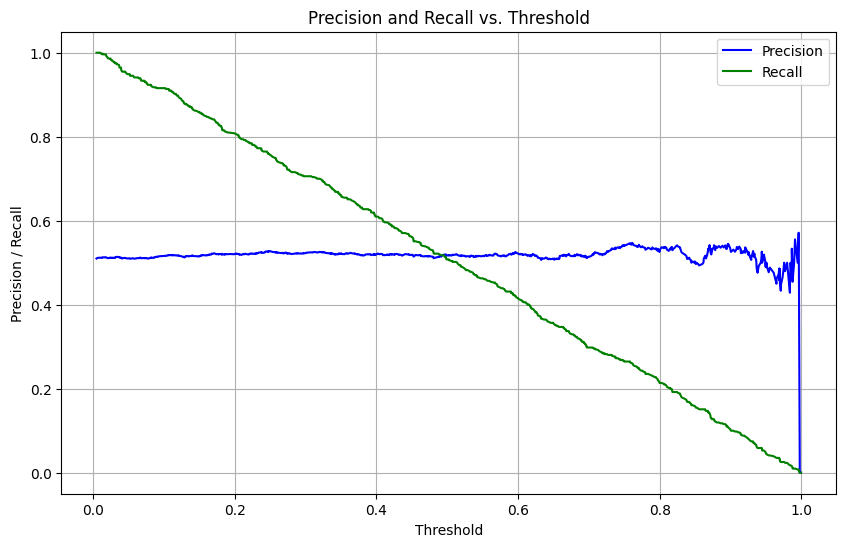

The precision and recall curves intersect at threshold: 0.493


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

np.random.seed(42)
y_true = np.random.randint(0, 2, 1000)
y_scores = np.random.rand(1000)

precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="b")
plt.plot(thresholds, recalls[:-1], label="Recall", color="g")
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision and Recall vs. Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.show()

diff = np.abs(precisions[:-1] - recalls[:-1])
intersection_index = np.argmin(diff)
intersection_threshold = thresholds[intersection_index]

print(f"The precision and recall curves intersect at threshold: {intersection_threshold:.3f}")


<ipython-input-11-144177b24dc1>:11: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


ValueError: x and y must have same first dimension, but have shapes (999,) and (1000,)

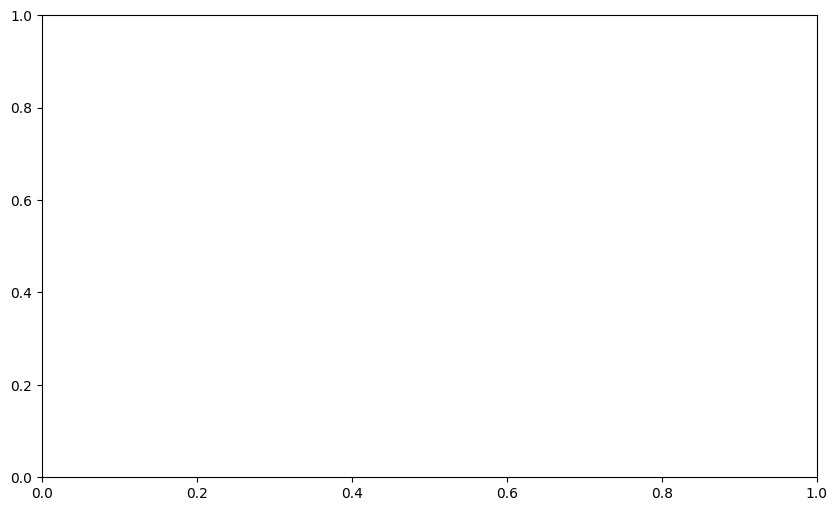

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

np.random.seed(42)
y_true = np.random.randint(0, 2, 1000)
y_scores = np.random.rand(1000)

precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores[np.isnan(f1_scores)] = 0

max_f1_index = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_index]

plt.figure(figsize=(10, 6))
plt.plot(thresholds[:-1], f1_scores[:-1], label="F1 Score", color="r")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.axvline(x=max_f1_threshold, color='k', linestyle='--', label=f'Max F1 at {max_f1_threshold:.2f}')
plt.legend(loc="best")
plt.grid(True)
plt.show()

print(f"The maximum F1 score is at threshold: {max_f1_threshold:.3f}")


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


np.random.seed(42)
X = np.random.rand(1000, 10)
y = np.random.randint(0, 2, 1000)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

std_dev = np.std(auc_scores)

print(f"Standard deviation of AUC scores across different folds: {std_dev:.4f}")


Standard deviation of AUC scores across different folds: 0.0311


In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


np.random.seed(42)
X = np.random.rand(1000, 10)
y = np.random.randint(0, 2, 1000)

C_values = [0.000001, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)
results = {}

for C in C_values:
    auc_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    results[C] = (round(mean_auc, 3), round(std_auc, 3))


best_C = max(results, key=lambda k: results[k][0])
best_mean_score = results[best_C][0]
best_std_score = results[best_C][1]

print("Results:")
for C, (mean_auc, std_auc) in results.items():
    print(f"C: {C}, Mean AUC: {mean_auc}, Std AUC: {std_auc}")

print(f"\nBest C: {best_C} with Mean AUC: {best_mean_score} (Std: {best_std_score})")


Results:
C: 1e-06, Mean AUC: 0.518, Std AUC: 0.026
C: 0.001, Mean AUC: 0.522, Std AUC: 0.029
C: 1, Mean AUC: 0.523, Std AUC: 0.031

Best C: 1 with Mean AUC: 0.523 (Std: 0.031)
